<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_8/8_3_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
batch_size = 128

transform = transforms.ToTensor()  # перетворює в [0,1] тензор розміром [1,28,28]
train_dataset = datasets.MNIST(root="./data", train=True,
                               transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False,
                               transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))

Train size: 60000
Test size : 10000


In [ ]:
# Параметри мережі
original_dim    = 28 * 28   # 784
intermediate_dim = 512
latent_dim       = 2
epochs           = 50

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)     # z_mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)   # z_log_var

    def forward(self, x):
        # x: [batch, 784]
        h = F.relu(self.fc1(x))
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        return z_mean, z_logvar


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc_out(h))
        return x_recon

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, z_mean, z_logvar):
        # z = mean + std * eps, eps ~ N(0, I)
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + std * eps

    def forward(self, x):
        # x: [batch, 784]
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_logvar

In [ ]:
def vae_loss_function(x_recon, x, z_mean, z_logvar):
    # BCE по всіх пікселях
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)

    # KL
    kl = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=1)
    kl_loss = kl.mean()

    return recon_loss + kl_loss

In [ ]:
vae = VAE(original_dim, intermediate_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

print(vae)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc_mean): Linear(in_features=512, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=512, bias=True)
    (fc_out): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [ ]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for x_batch, _ in loader:
        x_batch = x_batch.to(device).view(-1, original_dim)

        optimizer.zero_grad()
        x_recon, z_mean, z_logvar = model(x_batch)
        loss = vae_loss_function(x_recon, x_batch, z_mean, z_logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    return total_loss / len(loader.dataset)


In [ ]:
for epoch in range(1, epochs + 1):
    train_loss = train_epoch(vae, train_loader, optimizer, device)

    print(f"Epoch {epoch:3d} | train loss: {train_loss:.4f}")

Epoch   1 | train loss: 160.5318
Epoch   2 | train loss: 158.7258
Epoch   3 | train loss: 157.4158
Epoch   4 | train loss: 156.3537
Epoch   5 | train loss: 155.4272
Epoch   6 | train loss: 154.5450
Epoch   7 | train loss: 153.7912
Epoch   8 | train loss: 153.0086
Epoch   9 | train loss: 152.4411
Epoch  10 | train loss: 151.8422
Epoch  11 | train loss: 151.3599
Epoch  12 | train loss: 150.9420
Epoch  13 | train loss: 150.5345
Epoch  14 | train loss: 150.1964
Epoch  15 | train loss: 149.9279
Epoch  16 | train loss: 149.5639
Epoch  17 | train loss: 149.2267
Epoch  18 | train loss: 148.9779
Epoch  19 | train loss: 148.6714
Epoch  20 | train loss: 148.4971
Epoch  21 | train loss: 148.2850
Epoch  22 | train loss: 148.0498
Epoch  23 | train loss: 147.8098
Epoch  24 | train loss: 147.6341
Epoch  25 | train loss: 147.4592
Epoch  26 | train loss: 147.2924
Epoch  27 | train loss: 147.0419
Epoch  28 | train loss: 146.9828
Epoch  29 | train loss: 146.8066
Epoch  30 | train loss: 146.6693
Epoch  31 

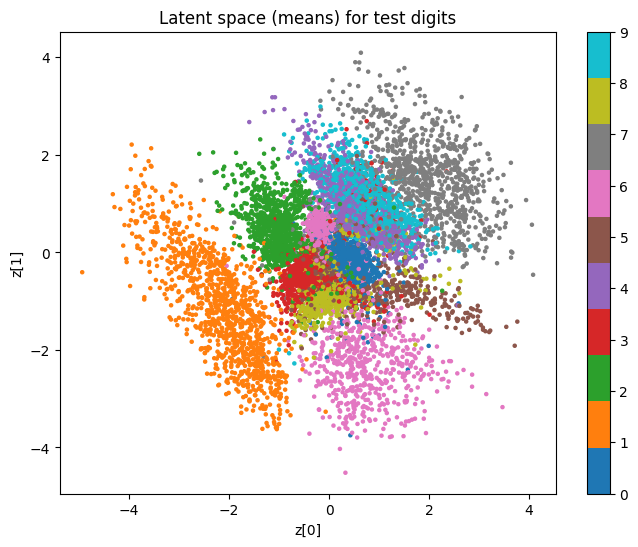

In [ ]:
# 2D plot латентного простору

vae.eval()
all_z = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.view(-1, original_dim).to(device)
        z_mean, z_logvar = vae.encoder(x_batch)
        all_z.append(z_mean.cpu().numpy())
        all_labels.append(y_batch.numpy())

z = np.concatenate(all_z, axis=0)
labels = np.concatenate(all_labels, axis=0)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="tab10", s=5)
plt.colorbar(scatter)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent space (means) for test digits")
plt.show()


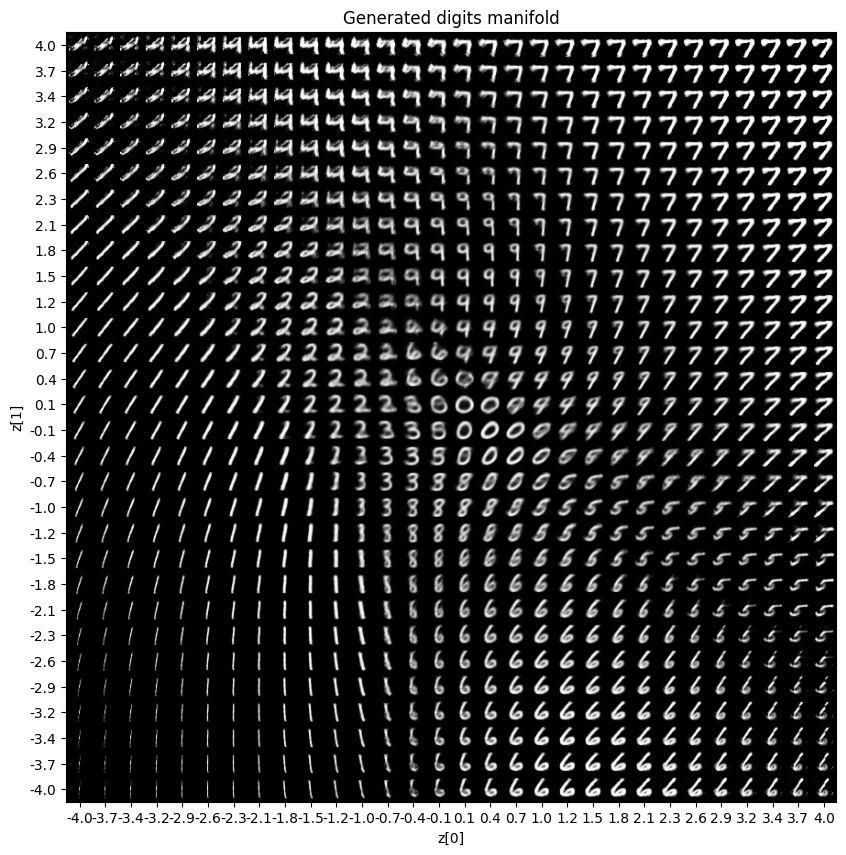

In [ ]:

# 30x30 маніфолд цифр у просторі z

n = 30
digit_size = 28

# координати в латентному просторі ([-4, 4] x [-4, 4], як у Keras-прикладі)
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]  # перевертаємо, щоб «не догори ногами»

figure = np.zeros((digit_size * n, digit_size * n))

vae.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded.cpu().numpy().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.title("Generated digits manifold")
plt.show()
